<a href="https://colab.research.google.com/github/TiGaI/HousingPriceKaggleProject3/blob/master/ames_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

**Jupyterhub sux**


---



In [0]:
train = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/TiGaI/HousingPriceKaggleProject3/master/data/test.csv')

In [64]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


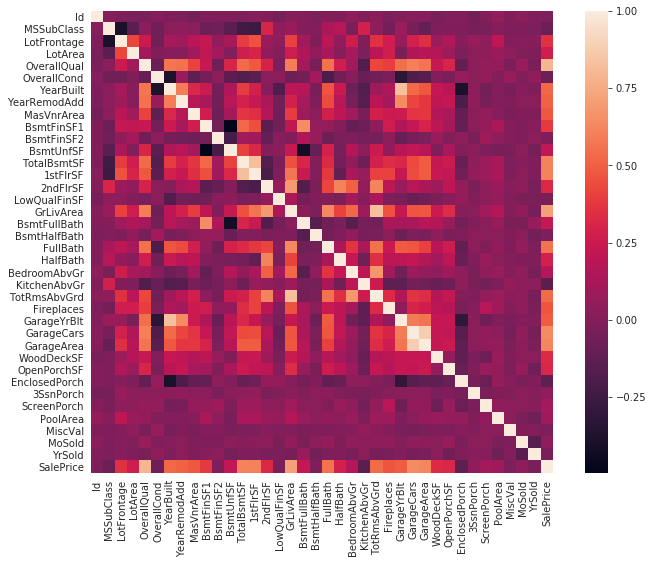

In [65]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train.corr(),square=True)

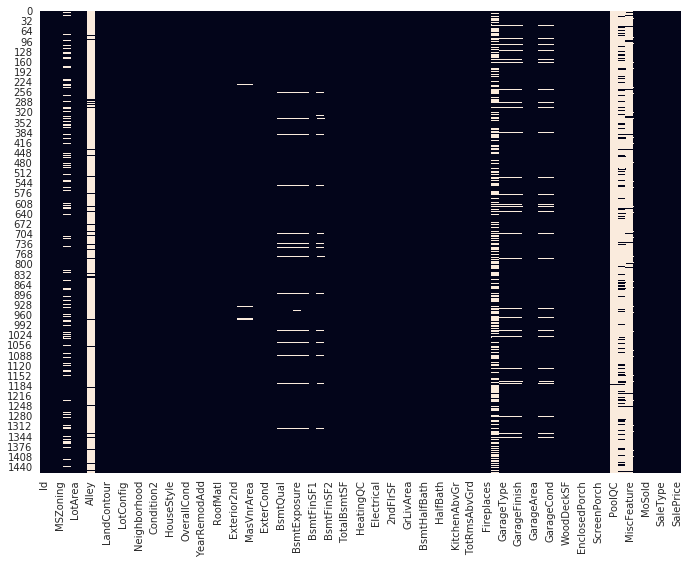

In [66]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
sns.set_style("white")
sns.heatmap(train.isnull(), cbar=False)

In [67]:
np.mean(train.isnull()).sort_values(ascending=False)
'''
Dummify: MiscFeature,
Delete: Alley
'''

'\nDummify: MiscFeature,\nDelete: Alley\n'

In [68]:
train.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

In [69]:
#split numerical and catergorical values
numTrain = train.loc[:, train.dtypes != 'object'].drop('Id', axis=1)
catTrain = train.loc[:, train.dtypes == 'object']
print(numTrain.columns)
print(catTrain.columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'Heatin

In [70]:
#num columns we filling in missing value with zero
numTrain['LotFrontage'].fillna(0, inplace=True)
numTrain['MasVnrArea'].fillna(0, inplace=True)
numTrain['Pool'] = numTrain['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#cat columns
catTrain['MasVnrType'].fillna("None", inplace=True)
catTrain['PoolQC'].fillna("None",inplace=True)
Replacement = {
   'PoolQC': {
      'None':0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   }
}

catTrain.replace(Replacement, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [71]:
garabgeReplacement = {
   'GarageQual': {
      np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'GarageCond': {
      np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
   },
    'GarageFinish': {
      np.nan:0, 'Unf': 1, 'RFn': 2, 'Fin': 3
   }
}

BsmtReplacement = {
   'BsmtFinType1': {
      np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
   },
    'BsmtFinType2': {
      np.nan:0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6
   },
    'BsmtExposure': {
        np.nan:0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4
    },
    'BsmtCond': {
        np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
    'BsmtQual': {
        np.nan:0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    },
}

FirePlaceReplacement ={
    'FireplaceQu': {
        np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
    }
}

catTrain = catTrain.replace(garabgeReplacement, inplace=False)

catTrain["Aver_GarageQual"] = (catTrain["GarageQual"] + catTrain["GarageCond"])/2
catTrain = catTrain.replace(BsmtReplacement)
numTrain['GarageYrBlt'].fillna(numTrain['YearBuilt'], inplace=True)
catTrain['GarageType'].fillna("None", inplace=True)
catTrain["BsmtCond"] = catTrain["BsmtCond"].astype(np.int64)

catTrain['Electrical'].fillna('SBrkr', inplace=True)


# print(numTrain['SalePrice'].corr(catTrain1['GarageQual']))
# print(numTrain['SalePrice'].corr(catTrain1['GarageCond']))
# print(numTrain['SalePrice'].corr(catTrain1["Aver_GarageQual"]))
# plt.scatter(x=catTrain1['GarageQual'], y=catTrain1['GarageCond'])
print(numTrain['SalePrice'].corr(catTrain["BsmtFinType1"])) # 0.3049 Main Basement <- Xiangwei
print(numTrain['SalePrice'].corr(catTrain["BsmtFinType2"])) #-0.005 no correlation - drop later

### convert the BsmtCond 

print(numTrain['SalePrice'].corr(catTrain["BsmtCond"])) #0.2126071564855789

print(numTrain['SalePrice'].corr(catTrain["BsmtQual"]))
print(numTrain['SalePrice'].corr(catTrain["BsmtCond"]))
print(catTrain["BsmtCond"].corr(catTrain["BsmtQual"]))

0.30490787307063294
-0.005323160673474955
0.21260715648557924
0.5852071991725198
0.21260715648557924
0.6337134125275647


In [72]:
numTrain.corr()['PoolArea'].sort_values(ascending=False)

PoolArea         1.000000
Pool             0.989665
GrLivArea        0.170205
BsmtFinSF1       0.140491
1stFlrSF         0.131525
TotalBsmtSF      0.126053
LotFrontage      0.114106
Fireplaces       0.095074
SalePrice        0.092404
TotRmsAbvGrd     0.083757
2ndFlrSF         0.081487
LotArea          0.077672
WoodDeckSF       0.073378
BedroomAbvGr     0.070703
BsmtFullBath     0.067616
OverallQual      0.065166
LowQualFinSF     0.062157
GarageArea       0.061047
OpenPorchSF      0.060762
EnclosedPorch    0.054203
ScreenPorch      0.051307
FullBath         0.049604
BsmtFinSF2       0.041709
MiscVal          0.029669
HalfBath         0.022381
GarageCars       0.020934
BsmtHalfBath     0.020025
MasVnrArea       0.011928
MSSubClass       0.008283
YearRemodAdd     0.005829
YearBuilt        0.004950
OverallCond     -0.001985
3SsnPorch       -0.007992
GarageYrBlt     -0.008004
KitchenAbvGr    -0.014525
MoSold          -0.033737
BsmtUnfSF       -0.035092
YrSold          -0.059689
Name: PoolAr

AttributeError: ignored

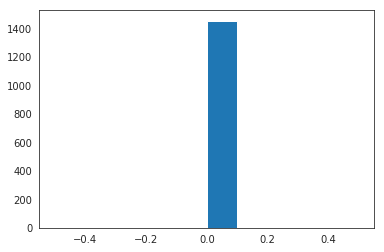

In [73]:
numTrain[numTrain['PoolArea'] < 0.1]['PoolArea'].hist(bin=5)

In [0]:
#fig, ax = plt.subplots(figsize=(11.5,8.5))
# numTrain['SalePrice'].boxplot(by=catTrain['Fence'])
train['Fence'].fillna('None', inplace=True)
train.boxplot(column = 'SalePrice',by='Fence')

In [0]:
train['Alley'].replace('None', np.nan)
train.boxplot(column = 'SalePrice',by='Alley')

In [0]:
train['MiscFeature'].fillna('None', inplace=True)
train.boxplot(column = 'SalePrice',by='MiscFeature')

In [0]:
fig, ax = plt.subplots(figsize=(11.5,8.5))
plt.scatter(x=numTrain['GarageYrBlt'], y=numTrain['YearBuilt'])
#plt.set_label()

In [0]:
#numTrain['Yeardiff'] = numTrain['GarageYrBlt'] - numTrain['YearBuilt']
catTrain['Alley'].value_counts(dropna=False)
# numTrain['Fireplaces'].value_counts(dropna=False)
# catTrain[catTrain['Electrical'].isnull()]

In [0]:
numTrain['GarageType'].corr(numTrain['PoolArea'])

In [0]:
print(catTrain['BsmtCond'].value_counts(dropna=False))
print(catTrain['BsmtFinType2'].value_counts(dropna=False))
# print(catTrain['BsmtFinType1'].value_counts(dropna=False))
# print(catTrain['BsmtFinType1'].value_counts(dropna=False))

In [0]:
fence_count = train['Fence'].value_counts()
sns.barplot(fence_count.index, fence_count.values, alpha = 0.6)

In [0]:
alley_count = train['Alley'].value_counts()
sns.barplot(alley_count.index, alley_count.values, alpha = 0.6)

In [0]:
numTrain['SalePrice'].corr(numTrain['Yeardiff']) #### -0.175183 very small
numTrain['GarageYrBlt'].corr(numTrain['SalePrice']) #### 0.486
numTrain['YearBuilt'].corr(numTrain['SalePrice'])  #### 0.52289

In [0]:
numTrain['GarageYrBlt'].value_counts(dropna=False)

In [0]:
train['MiscFeature'].value_counts()

#type(catTrain['MasVnrType'][2])

#type(catTrain)

In [0]:
numTrain[numTrain['MasVnrArea'] < 200]['MasVnrArea'].hist(bins=20)

In [0]:
np.count_nonzero(train['PoolArea'])

In [0]:
train['LotFrontage'].value_counts(dropna=False)

In [0]:
# Features Selection
# 1. Total number of Bathrooms
# TotBathrooms = FullBath + (HalfBath*0.5) + BsmtFullBath + (BsmtHalfBath*0.5)
# 2. there are 3 variables that are relevant with regards to the Age of a house; YearBlt, YearRemodAdd, and YearSold
# Combinding yearSale - yearRemodAdd, remodel into yes or no, and  to house age. There should be a negative correlation
# 3. Binning Neighborhood - to reduce dimensionality from neighbrohood overdimensionality from dummieing it.
# Seperate into 4 bins which be idea for 0-25%, 26-50%, 51-75%, 75-100%
# You can also do whatever bins you want, suggest less than 5
# 4. Total Square Feet - adding all squarefeet from all levels of housing, thus if house is 4 levels, you add all sf from all floor.
# Should be a direct correlation
#
